# iCAT Montage
---
Overview and interactive walkthrough of how to align sections using `render-python`. Assumes image data has already been imported following the [iCAT-import workflow](https://github.com/lanery/iCAT-workflow/blob/master/notebooks/iCAT-import.ipynb).

## 1 Generate Pointmatches
---

### 1.0 Imports

In [1]:
# Libraries needed
import os
import subprocess
from functools import partial
import re
from pathlib import Path
import json
from io import BytesIO

import requests
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1 import make_axes_locatable
from seaborn import distributions
from skimage.io import imread

import renderapi
from renderapi.client import (SiftPointMatchOptions,
                              MatchDerivationParameters,
                              FeatureExtractionParameters,
                              ArgumentParameters)

In [2]:
# Set up environment
%matplotlib inline
pd.options.mode.chained_assignment = None
np.set_printoptions(suppress=True)
pd.set_option('display.max_colwidth', -1)

### 1.1 Set up render environment

In [3]:
owner = 'rlane'  # replace with your name
project = '20190517_UMCG_RL005'
project_dir = Path(f'/long_term_storage/{owner}/SECOM/projects/{project}/')

# Create a renderapi.connect.Render object
render_connect_params = {
    'host': 'sonic',
    'port': 8080,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G'
}

render = renderapi.connect(**render_connect_params)
stacks = renderapi.render.get_stacks_by_owner_project(render=render)

# Select stacks for montaging
montage_stacks = ['lil_EM']
match_collections = {}
for stack in montage_stacks:
    match_collections[stack] = f'{project}_{stack}_points'
    
out = f"""\
stacks.............. {stacks}
montage stacks...... {montage_stacks}
match collections... {match_collections}
"""
print(out)

stacks.............. ['lil_EM', 'hoechst', 'big_EM']
montage stacks...... ['lil_EM']
match collections... {'lil_EM': '20190517_UMCG_RL005_lil_EM_points'}



#### Map of all sections with corresponding z values for each stack

In [4]:
stack_data = pd.DataFrame(columns=['stack', 'section', 'z'])

i = 0
for stack in stacks:
    # Get z values for each stack
    z_vals = renderapi.stack.get_z_values_for_stack(stack, render=render)
    for z in z_vals:
        # Get sectionId for z value
        section = renderapi.stack.get_sectionId_for_z(stack, z, render=render)
        # Build up stack data
        stack_data.loc[i, 'stack'] = stack
        stack_data.loc[i, 'z'] = z
        stack_data.loc[i, 'section'] = section
        # Increment index
        i += 1
        
stack_data.infer_objects()

,stack,section,z
0,lil_EM,S001,1.0
1,hoechst,S001,1.0
2,big_EM,S001,1.0


### 1.2 Get Tile Pairs
Tile pairs are any two tiles that overlap with each other (possibly including diagonally). To generate a list of tile pairs we invoke  
[`renderapi.client.tilePairClient`](https://github.com/fcollman/render-python/blob/721ac8845e3067af6c81f3c67f2c0fa24fb1723c/renderapi/client/client_calls.py#L129)

This client selects a set of tiles `p` based on its position in a stack and then searches for nearby `q` tiles using geometric parameters  
[`TilePairClient.java`](https://github.com/saalfeldlab/render/blob/master/render-ws-java-client/src/main/java/org/janelia/render/client/TilePairClient.java)

In [5]:
tile_pairs = pd.DataFrame(columns=['stack', 'section', 'z', 'pid', 'qid'])

i = 0
for stack in stacks:
    
    # Only attempt to get tile pairs if stack contains > 1 tile
    N_tiles = len(renderapi.stack.get_stack_tileIds(stack, render=render))
    if N_tiles > 1:
        
        # Get stack's positional bounds
        bounds = renderapi.stack.get_stack_bounds(stack, render=render)
        
        # Generate tile pairs
        tile_pairs_json = renderapi.client.tilePairClient(stack,
                                                          minz=bounds['minZ'],
                                                          maxz=bounds['maxZ'],
                                                          render=render)
        # Build up DataFrame of tile pairs
        for tp in tile_pairs_json['neighborPairs']:
            tile_pairs.loc[i, 'stack'] = stack
            tile_pairs.loc[i, 'section'] = tp['p']['groupId']
            tile_pairs.loc[i, 'z'] = renderapi.stack.get_section_z_value(stack, section, render=render)
            tile_pairs.loc[i, 'pid'] = tp['p']['id']
            tile_pairs.loc[i, 'qid'] = tp['q']['id']
            i += 1

In [6]:
# Reset index just in case
tile_pairs.reset_index(inplace=True, drop=True)
# Filter out non-montage stacks
tile_pairs = tile_pairs[tile_pairs['stack'].isin(match_collections)]
# Preview
tile_pairs.groupby('stack').apply(lambda x: x.head())

stack section  z                          pid  \
stack                                                      
lil_EM 0  lil_EM  S001    1  aaa_lil_EM-S001-00000x00033   
       1  lil_EM  S001    1  aaa_lil_EM-S001-00000x00033   
       2  lil_EM  S001    1  aab_lil_EM-S001-00001x00033   
       3  lil_EM  S001    1  aab_lil_EM-S001-00001x00033   
       4  lil_EM  S001    1  aac_lil_EM-S001-00002x00033   

                                  qid  
stack                                  
lil_EM 0  acv_lil_EM-S001-00000x00032  
       1  aab_lil_EM-S001-00001x00033  
       2  acu_lil_EM-S001-00001x00032  
       3  aac_lil_EM-S001-00002x00033  
       4  act_lil_EM-S001-00002x00032

### 1.3 Run Point Match Client
Set SIFT and RANSAC parameters.

In [21]:
match_params = MatchDerivationParameters(matchIterations=None,
                                         matchMaxEpsilon=25,        # maximal alignment error
                                         matchMaxNumInliers=None,
                                         matchMaxTrust=None,
                                         matchMinInlierRatio=0.05,  # minimal inlier ratio
                                         matchMinNumInliers=7,      # minimal number of inliers
                                         matchModelType='RIGID',    # expected transformation
                                         matchRod=0.92)             # closest/next closest ratio
feature_params = FeatureExtractionParameters(SIFTfdSize=4,          # feature descriptor size
                                             SIFTmaxScale=0.25,     # (width/height *) maximum image size
                                             SIFTminScale=0.05,     # (width/height *) minimum image size
                                             SIFTsteps=6,           # steps per scale octave
                                             clipWidth=500,
                                             clipHeight=500)

sift_options = SiftPointMatchOptions(**{**match_params.__dict__,
                                        **feature_params.__dict__})

Create a wrapper for `renderapi.client.pointMatchClient` so that we can run the point match client on multiple threads with `renderapi.client.WithPool`.

In [10]:
def run_point_match_client(tile_pair_chunk, stack, collection, sift_options, render):
    """
    Point match client wrapper for use in multiprocessing
    """
    renderapi.client.pointMatchClient(stack=stack,
                                      collection=collection,
                                      tile_pairs=tile_pair_chunk,
                                      sift_options=sift_options,
                                      render=render)

Run the point match client (the function that actually finds features and whatnot) over chunks of tile pairs. Have to use `partial` with `WithPool` because otherwise it would be too easy. Adjust `N_cores` as necessary. For large (4k x 4k) images, `N_cores` may have to be reduced to ~10.
#### \*\****COMPUTATIONALLY EXPENSIVE*** \**

In [11]:
N_cores = 10
chunk_size = 6

for (section, stack), tps in tqdm_notebook(tile_pairs.groupby(['section', 'stack'])):
    
    grouping = np.arange(len(tps)) // chunk_size
    for i, chunk in tqdm_notebook(tps.groupby(grouping)):
        
        # Have to wrap up each tile pair all neat and nicelike
        tp_chunk = [[tuple(tp)] for tp in chunk[['pid', 'qid']].values.tolist()]
        
        # Set up pointmatch client
        point_match_client_partial = partial(run_point_match_client,
                                             stack=stack,
                                             collection=match_collections[stack],
                                             sift_options=sift_options,
                                             render=render)
        # Run point match client with `N_cores`
        with renderapi.client.WithPool(N_cores) as pool:
            pool.map(point_match_client_partial, tp_chunk)

## 2 Point match analysis
---
### 2.1 Aggregate point matches
**Not set up for multiple sections**

In [31]:
# Create empty dataframe in which to store results
point_matches = pd.DataFrame(columns=['stack', 'section', 'z', 'N_matches',
                                      'pc', 'pr', 'qc', 'qr', 'pid', 'qid'])

for i, tp in tile_pairs.iterrows():
    
    # Get group IDs
    stack = tp['stack']
    groupIds = renderapi.pointmatch.get_match_groupIds(match_collections[stack], render=render)
    # TODO: Loop through groupIds to add support for multiple sections
    tile_pair_matches = renderapi.pointmatch.get_matches_from_tile_to_tile(
                            match_collections[stack],
                            pgroup=groupIds[0],
                            pid=tp['pid'],
                            qgroup=groupIds[0],
                            qid=tp['qid'],
                            render=render)
    
    # Suss out column and row number from tileId
    pc, pr = [int(i) for i in re.findall('\d+', tp['pid'])[-2:]]
    qc, qr = [int(i) for i in re.findall('\d+', tp['qid'])[-2:]]
    
    try:
        # Stuff matches into arrays
        p_matches = np.array(tile_pair_matches[0]['matches']['p']).T
        q_matches = np.array(tile_pair_matches[0]['matches']['q']).T
        # Ensure p and q matches check out
        assert len(p_matches) == len(q_matches)
    
    except IndexError:
        # No matches for this tile pair
        p_matches = []
        q_matches = []
    
    point_matches.loc[i, ['stack', 'section', 'z']] = tp[['stack', 'section', 'z']]
    point_matches.loc[i, ['pid','qid']] = tp[['pid', 'qid']]
    point_matches.loc[i, ['pc','pr','qc','qr']] = (pc, pr, qc, qr)
    point_matches.loc[i, 'N_matches'] = len(p_matches)
    
# Preview dataframe
point_matches = point_matches.infer_objects()
point_matches.groupby('stack').apply(lambda x: x.sample(3))

stack section    z  N_matches  pc  pr  qc  qr  \
stack                                                         
lil_EM 1052  lil_EM  S001    1.0  389        18  19  19  19   
       2280  lil_EM  S001    1.0  292        14  0   13  0    
       1813  lil_EM  S001    1.0  244        7   8   6   8    

                                     pid                          qid  
stack                                                                  
lil_EM 1052  aun_lil_EM-S001-00018x00019  auo_lil_EM-S001-00019x00019  
       2280  bta_lil_EM-S001-00014x00000  btb_lil_EM-S001-00013x00000  
       1813  bjl_lil_EM-S001-00007x00008  bjm_lil_EM-S001-00006x00008

### 2.2 Point match heatmaps
#### East-West point matches

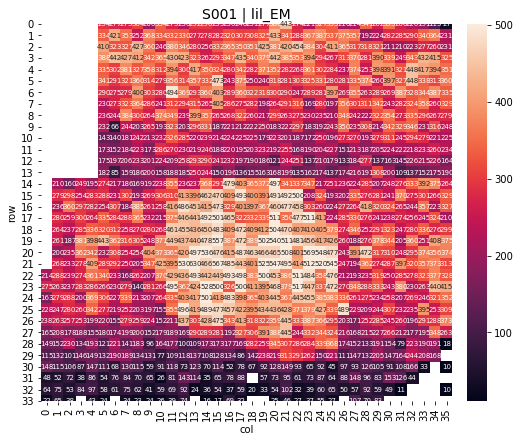

In [32]:
# Set up figure
nrows = len(point_matches['section'].unique())
fig, ax = plt.subplots(nrows=nrows, figsize=(8, 8*nrows))

for i, ((stack, section), pms) in enumerate(point_matches.groupby(['stack', 'section'])):
    
    # Filter out East-West tile pairs
    EW_matches = pms[pms['pr'] == pms['qr']]
    EW_matches['pqc'] = EW_matches[['pc', 'qc']].min(axis=1)
    
    # Add custom cbar axis
    divider = make_axes_locatable(ax)
    ax_cbar = divider.new_horizontal(size='5%', pad=0.2, pack_start=False)
    fig.add_axes(ax_cbar)
    
    EW = EW_matches.pivot('pr', 'pqc', 'N_matches')
    sns.heatmap(EW, annot=True, mask=EW<10, fmt='.0f', robust=True, square=True, cbar_ax=ax_cbar,
                ax=ax, annot_kws={'fontsize': 7})
    
    # Figure aesthetics
    ax.set_title(f'{section} | {stack}', fontsize=14)
    ax.set_xlabel('col')
    ax.set_ylabel('row')

#### North-South point matches

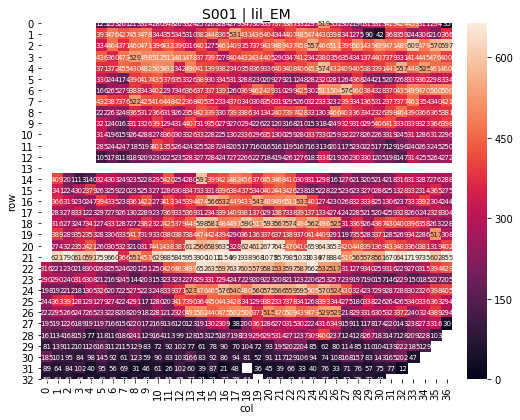

In [33]:
# Set up figure
nrows = len(point_matches['section'].unique())
fig, ax = plt.subplots(nrows=nrows, figsize=(8, 8*nrows))

for i, ((stack, section), pms) in enumerate(point_matches.groupby(['stack', 'section'])):
    
    # Filter out East-West tile pairs
    NS_matches = pms[pms['pc'] == pms['qc']]
    NS_matches['pqr'] = NS_matches[['pr', 'qr']].min(axis=1)
    
    # Add custom cbar axis
    divider = make_axes_locatable(ax)
    ax_cbar = divider.new_horizontal(size='5%', pad=0.2, pack_start=False)
    fig.add_axes(ax_cbar)
    
    NS = NS_matches.pivot('pqr', 'pc', 'N_matches')
    sns.heatmap(NS, annot=True, mask=NS<10, fmt='.0f', robust=True, square=True, cbar_ax=ax_cbar,
                ax=ax, annot_kws={'fontsize': 7})
    
    # Figure aesthetics
    ax.set_title(f'{section} | {stack}', fontsize=14)
    ax.set_xlabel('col')
    ax.set_ylabel('row')

### 2.3 Point match distribution

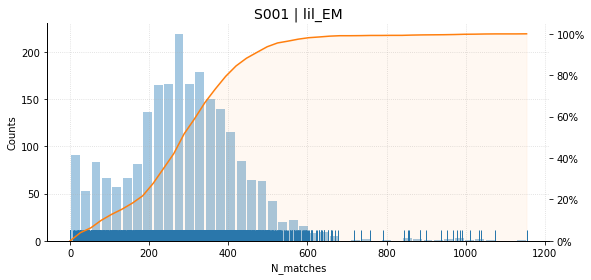

In [34]:
# Set up figure
nrows = len(point_matches['section'].unique())
fig, ax = plt.subplots(nrows=nrows, figsize=(9, 4*nrows))

for i, ((stack, section), pms) in enumerate(point_matches.groupby(['stack', 'section'])):
    
    # Compute cumulative distribution
    nbins = 64 if len(pms) < 64 else distributions._freedman_diaconis_bins(pms['N_matches'])
    hist, bins = np.histogram(pms['N_matches'], bins=nbins)
    cumdist = np.cumsum(hist)
    
    # Plot distribution of N_matches
    sns.distplot(pms['N_matches'], bins=nbins, kde=False, rug=True,
                 hist_kws={'rwidth': 0.85}, label=stack, ax=ax)
    
    # Plot cumulative distribution
    cumdist = cumdist / cumdist.max()
    cumdist = np.insert(cumdist, 0, 0)
    percent = np.linspace(0, 100, cumdist.size)
    axc = ax.twinx().twiny()
    axc.plot(percent, cumdist/cumdist.max(), color='C1')
    axc.fill_between(percent, 0, cumdist, color='C1', alpha=0.05)
    
    # Figure aesthetics
    ax.set_title(f'{section} | {stack}', fontsize=14)
    ax.set_ylabel('Counts')
    ax.grid(ls=':', alpha=0.5)
    axc.set_ylim(0, None)
    axc.axes.get_xaxis().set_ticks([])
    axc.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    sns.despine()

## 3 Refine point matches for problematic tile pairs
---
#### Bottom 10% of point matches

In [35]:
_10pct_threshold = 20 #np.percentile(point_matches['N_matches'], 10) or 10
reruns = point_matches[point_matches['N_matches'] < _10pct_threshold]
reruns.sort_values('N_matches')

,stack,section,z,N_matches,pc,pr,qc,qr,pid,qid
7,lil_EM,S001,1.0,0,3,33,4,33,aad_lil_EM-S001-00003x00033,aae_lil_EM-S001-00004x00033
1392,lil_EM,S001,1.0,0,26,14,26,13,bbe_lil_EM-S001-00026x00014,bcz_lil_EM-S001-00026x00013
1390,lil_EM,S001,1.0,0,27,14,27,13,bbd_lil_EM-S001-00027x00014,bda_lil_EM-S001-00027x00013
1388,lil_EM,S001,1.0,0,28,14,28,13,bbc_lil_EM-S001-00028x00014,bdb_lil_EM-S001-00028x00013
1386,lil_EM,S001,1.0,0,29,14,29,13,bbb_lil_EM-S001-00029x00014,bdc_lil_EM-S001-00029x00013
...,...,...,...,...,...,...,...,...,...,...
82,lil_EM,S001,1.0,11,32,32,31,32,abp_lil_EM-S001-00032x00032,abq_lil_EM-S001-00031x00032
81,lil_EM,S001,1.0,12,32,32,32,31,abp_lil_EM-S001-00032x00032,aec_lil_EM-S001-00032x00031
29,lil_EM,S001,1.0,16,14,33,15,33,aao_lil_EM-S001-00014x00033,aap_lil_EM-S001-00015x00033
31,lil_EM,S001,1.0,17,15,33,16,33,aap_lil_EM-S001-00015x00033,aaq_lil_EM-S001-00016x00033


### 3.1 Set more stringent SIFT parameters

In [29]:
match_params = MatchDerivationParameters(matchIterations=None,
                                         matchMaxEpsilon=25,        # maximal alignment error
                                         matchMaxNumInliers=None,
                                         matchMaxTrust=None,
                                         matchMinInlierRatio=0.05,  # minimal inlier ratio
                                         matchMinNumInliers=7,      # minimal number of inliers
                                         matchModelType='RIGID',    # expected transformation
                                         matchRod=0.92)             # closest/next closest ratio
feature_params = FeatureExtractionParameters(SIFTfdSize=4,          # feature descriptor size
                                             SIFTmaxScale=0.50,     # (width/height *) maximum image size
                                             SIFTminScale=0.02,     # (width/height *) minimum image size
                                             SIFTsteps=7,           # steps per scale octave
                                             clipWidth=500,
                                             clipHeight=500)

sift_options = SiftPointMatchOptions(**{**match_params.__dict__,
                                        **feature_params.__dict__})

### 3.2 Rerun PointMatchClient on problematic tile pairs
\*\****COMPUTATIONALLY EXPENSIVE*** \**

In [30]:
N_cores = 10
chunk_size = 6

for (section, stack), tps in tqdm_notebook(reruns.groupby(['section', 'stack'])):
    
    grouping = np.arange(len(tps)) // chunk_size
    for i, chunk in tqdm_notebook(tps.groupby(grouping)):
        
        # Have to wrap up each tile pair all neat and nicelike
        tp_chunk = [[tuple(tp)] for tp in chunk[['pid', 'qid']].values.tolist()]
        
        # Set up PointMatchClient
        point_match_client_partial = partial(run_point_match_client,
                                             stack=stack,
                                             collection=match_collections[stack],
                                             sift_options=sift_options,
                                             render=render)
        # Run PointMatchClient with `N_cores`
        with renderapi.client.WithPool(N_cores) as pool:
            pool.map(point_match_client_partial, tp_chunk)

## 4 Run EM Aligner
---
So now all the point matches have been generated, but the tiles have not been globally aligned. To do so, we use an additional package, also developed at the Allen Institute, [EM_aligner_python](https://github.com/AllenInstitute/EM_aligner_python).

### 4.1 Edit Montage json

In [36]:
template_montage_json = Path('/home/rlane/iCAT-workflow/templates/montage.json')
with template_montage_json.open('r') as json_data:
    montage_settings = json.load(json_data)
    
for (stack, section, z), pms in point_matches.groupby(['stack', 'section', 'z']):
    
    # Edit section data
    montage_settings['first_section'] = z
    montage_settings['last_section'] = z
    
    # Edit input stack data
    montage_settings['input_stack']['owner'] = owner
    montage_settings['input_stack']['project'] = project
    montage_settings['input_stack']['name'] = stack
    
    # Edit point match stack data
    montage_settings['pointmatch']['owner'] = owner
    montage_settings['pointmatch']['name'] = match_collections[stack]
    
    # Edit output stack data
    montage_settings['output_stack']['owner'] = owner
    montage_settings['output_stack']['project'] = project
    montage_settings['output_stack']['name'] = f'{stack}_montaged'
    
    # Edit regularization parameters
    montage_settings['regularization']['default_lambda'] = 10000.  # default 10000.0
    montage_settings['regularization']['translation_factor'] = 0.1  # default 0.1
    
    # Export montage settings to
    montage_json = project_dir/section/stack/'_montage.json'
    with montage_json.open('w') as json_data:
        json.dump(montage_settings, json_data, indent=2)

### 4.2 Change `mongod` configuration
Needs to be refined, but this works for now. Involves opening mongodb to remote IPs which might be dangerous.

Normal `/etc/mongod.conf` configuration
```
# network interfaces
net:
  port: 27017
#  bindIp: 0.0.0.0
  bindIp: 127.0.0.1 # Listen to local interface only, comment to listen on all interfaces.
#  bindIp: 127.0.0.1 169.254.100.2 131.180.83.183 172.17.0.1
```

Make changes and restart mongod
```
# network interfaces
net:
  port: 27017
  bindIp: 0.0.0.0
#  bindIp: 127.0.0.1 # Listen to local interface only, comment to listen on all interfaces.
#  bindIp: 127.0.0.1 169.254.100.2 131.180.83.183 172.17.0.1
```
### 4.3 Make call to EM Aligner

In [37]:
cwd = Path.cwd().as_posix()
EM_aligner_dir = Path('/home/catmaid/EM_aligner_python/').as_posix()

for (stack, section), pms in tqdm_notebook(point_matches.groupby(['stack', 'section'])):
    
    # Select montage settings
    montage_json = project_dir/section/stack/'_montage.json'
    
    # Call `EMaligner.EMaligner` process -- have to switch to EMaligner directory
    os.chdir(EM_aligner_dir)
    subprocess.run(['python', '-m', 'EMaligner.EMaligner', '--input_json', montage_json.as_posix()])
    os.chdir(cwd)

## 5 Inspect the montage
---

\*\****MAY TAKE AN EXTREMELY LONG TIME*** \**

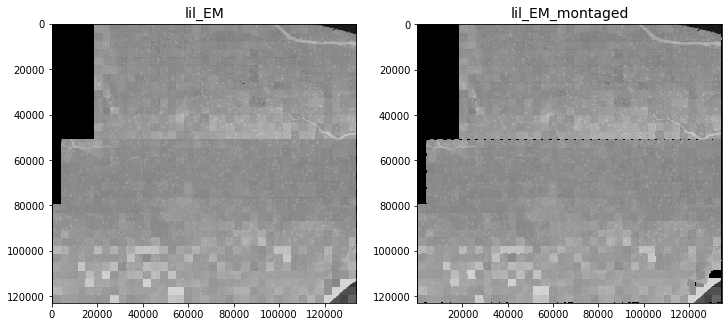

In [38]:
stacks = ['lil_EM', 'lil_EM_montaged']
sections = ['S001']

for (z, section), layer in tqdm_notebook(stack_data.groupby(['z', 'section']), total=len(sections)):
    
    # Set up figure
    ncols = len(stacks)
    fig, axes = plt.subplots(ncols=ncols, figsize=(6*ncols, 6))
    
    for c, stack in tqdm_notebook(enumerate(stacks), total=len(stacks)):
        
        # Get section bounds
        bounds = renderapi.stack.get_bounds_from_z(stack=stack,
                                                   z=z,
                                                   render=render)
        
        # Fetch section image per stack
        scale = 512 / (bounds['maxX'] - bounds['minX'])
        image = renderapi.image.get_section_image(stack=stack,
                                                  z=z,
                                                  scale=scale,
                                                  filter=False,
                                                  render=render)
        
        # Plot image
        extent = [bounds[k] for k in ['minX', 'maxX', 'minY', 'maxY']]  # [left, right, bottom, top]
        axes[c].imshow(image, extent=extent, origin='lower')
        
        # Axis aesthetics
        axes[c].invert_yaxis()
        if z == stack_data['z'].min():
            axes[c].set_title(f'{stack}', fontsize=14)